In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
import numpy as np

MU_SRC = np.array([[-15*np.sqrt(2), -15*np.sqrt(2)],
                   [ 15*np.sqrt(2),  15*np.sqrt(2)]], dtype=np.float64)

MU_TAR = np.array([[-15.0, 0.0],
                   [  0.0, 15.0]], dtype=np.float64)

def V(z_t: np.ndarray, t: float, c: str) -> np.ndarray:
    mu = MU_SRC if c == "src" else MU_TAR
    dists = np.sum((z_t[:, None, :] - mu[None, :, :])**2, axis=-1)  # (N,2)
    k = np.argmin(dists, axis=1)                                   # (N,)
    closest = mu[k]
    strength = 1.0 + 2.0*(1.0 - t)
    return strength * (closest - z_t)

In [46]:


def flowedit(X_src, T=60, dt=0.03, seed=123):
    rng = np.random.default_rng(seed)
    Z = X_src.copy()
    ts = np.linspace(1.0, 0.0, T)

    for t in ts:
        N = rng.standard_normal(X_src.shape)
        Z_src_t = (1.0 - t) * X_src + t * N
        Z_tar_t = Z + (Z_src_t - X_src)

        V_src = V(Z_src_t, t, "src")
        V_tar = V(Z_tar_t, t, "tar")
        Z = Z + dt * (V_tar - V_src)

    return Z


In [47]:
def editing_by_inversion(X_src, T=60, dt=0.03, seed=123):
    rng = np.random.default_rng(seed)

    # 1) "invert" to high noise (here t=1 => pure Gaussian)
    Z = rng.standard_normal(X_src.shape)      # this is the "noise space"
    X_noise = Z.copy()

    # 2) go back to data using ONLY the target dynamics (no fixed mode assignment!)
    ts = np.linspace(1.0, 0.0, T)
    for t in ts:
        Z = Z + dt * V(Z, t, "tar")

    return Z, X_noise

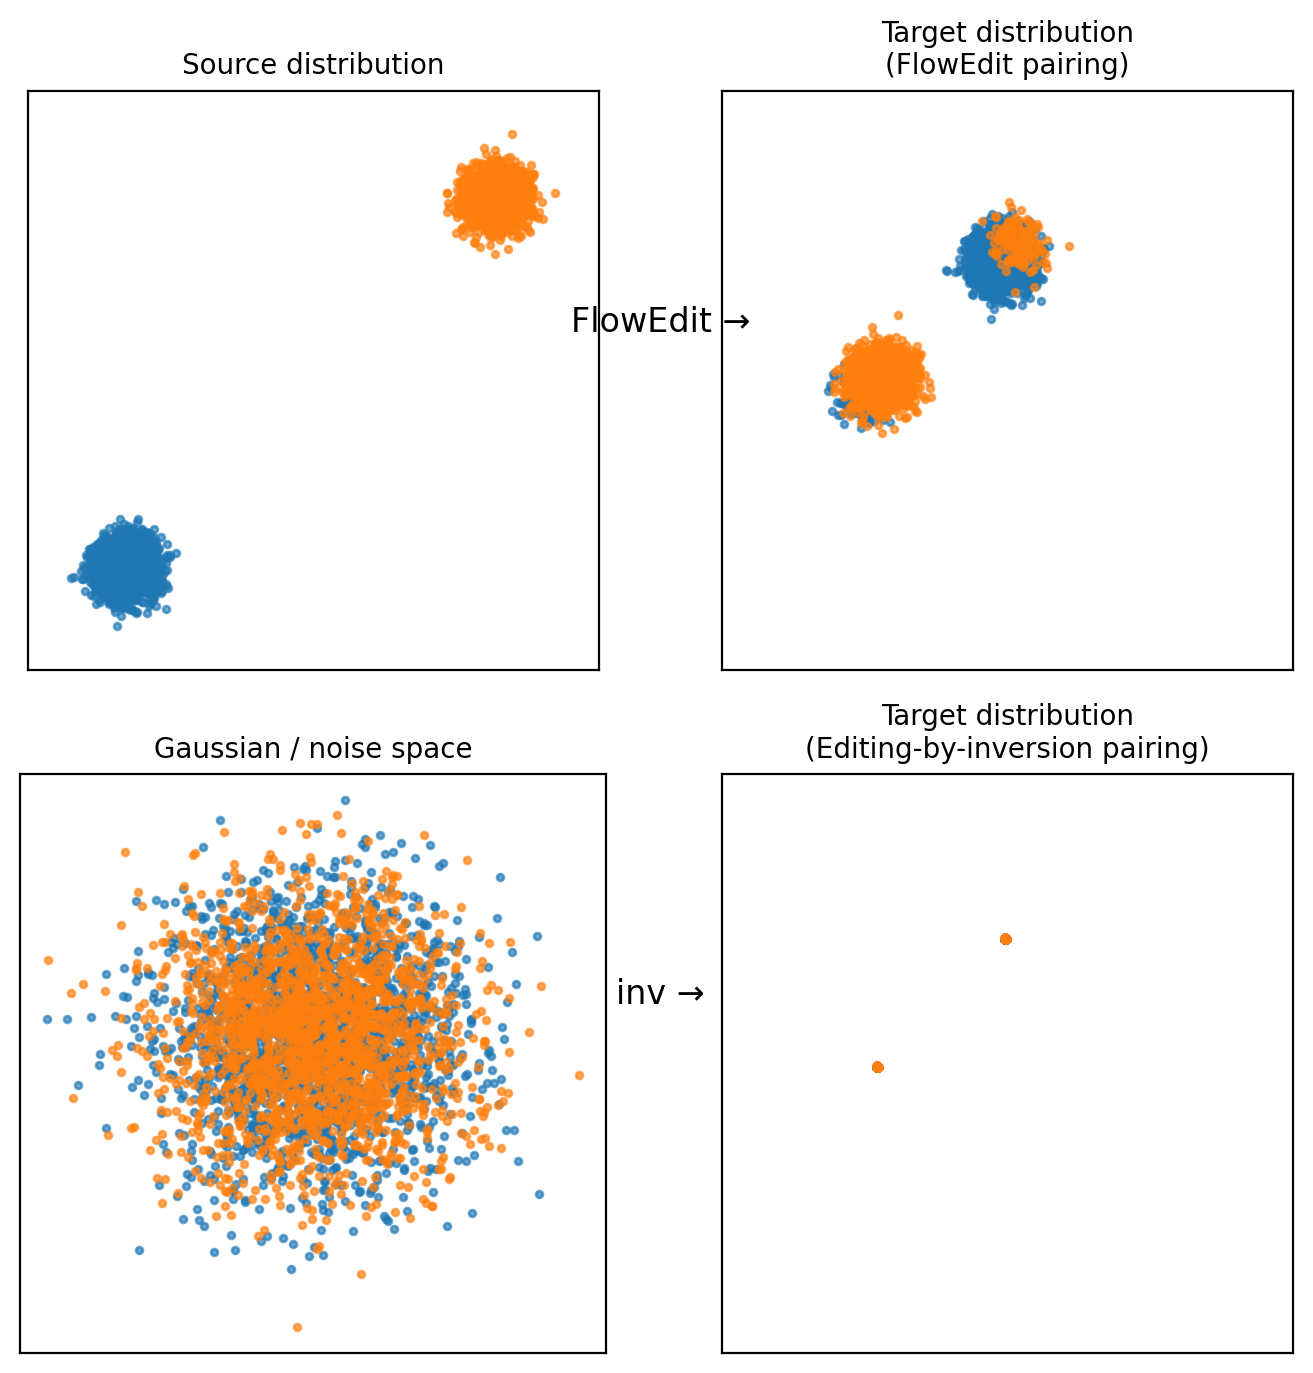

In [49]:
rng = np.random.default_rng(7)
N_PER_MODE = 2000
sigma = 1.8

# Make a 2-mode source distribution
n0 = rng.standard_normal((N_PER_MODE, 2))
n1 = rng.standard_normal((N_PER_MODE, 2))
X0 = MU_SRC[0] + sigma * n0
X1 = MU_SRC[1] + sigma * n1
X_src = np.vstack([X0, X1])
mode = np.array([0]*N_PER_MODE + [1]*N_PER_MODE)  # SOURCE labels (colors)

# Run FlowEdit
Z_fe = flowedit(X_src, T=60, dt=0.03, seed=123)

# Run Editing-by-Inversion (NO mode assignment!)
Z_inv, X_noise = editing_by_inversion(X_src, T=60, dt=0.03, seed=123)

# Plot like Fig.3 (2x2)
fig, axs = plt.subplots(2, 2, figsize=(7.2, 7.0), dpi=200)
(ax1, ax2), (ax3, ax4) = axs

def scat(ax, X, title):
    ax.scatter(X[mode==0, 0], X[mode==0, 1], s=6, alpha=0.65)
    ax.scatter(X[mode==1, 0], X[mode==1, 1], s=6, alpha=0.65)
    ax.set_title(title, fontsize=10)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linewidth=0.3, alpha=0.3)
    ax.set_xticks([]); ax.set_yticks([])

scat(ax1, X_src,   "Source distribution")
scat(ax2, Z_fe,    "Target distribution\n(FlowEdit pairing)")
scat(ax3, X_noise, "Gaussian / noise space")
scat(ax4, Z_inv,   "Target distribution\n(Editing-by-inversion pairing)")

# consistent bounds for the 3 data-space panels
all_xy = np.vstack([X_src, Z_fe, Z_inv, MU_SRC, MU_TAR])
xmin, ymin = all_xy.min(axis=0) - 5
xmax, ymax = all_xy.max(axis=0) + 5
for ax in [ax1, ax2, ax4]:
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

fig.text(0.50, 0.76, "FlowEdit →", ha="center", va="center", fontsize=12)
fig.text(0.50, 0.28, "inv →",     ha="center", va="center", fontsize=12)

plt.tight_layout(pad=1.2)
plt.savefig("fig3_like_flowedit_toy.png", bbox_inches="tight")
plt.show()

In [ ]:
# Diagnostics : vérifier les positions moyennes des clusters
print("Source distribution - Mode 0 mean:", X_src[mode==0].mean(axis=0))
print("Source distribution - Mode 1 mean:", X_src[mode==1].mean(axis=0))
print("\nTarget MU_TAR:", MU_TAR)
print("\nFlowEdit result - Mode 0 mean:", Z_fe[mode==0].mean(axis=0))
print("FlowEdit result - Mode 1 mean:", Z_fe[mode==1].mean(axis=0))
print("\nInversion result - Mode 0 mean:", Z_inv[mode==0].mean(axis=0))
print("Inversion result - Mode 1 mean:", Z_inv[mode==1].mean(axis=0))

Source distribution - Mode 0 mean: [-21.16212257 -21.32764861]
Source distribution - Mode 1 mean: [21.14740093 21.20894476]

Target MU_TAR: [[-15.   0.]
 [  0.  15.]]

FlowEdit result - Mode 0 mean: [-15.0990299   -0.62695538]
FlowEdit result - Mode 1 mean: [ 0.44670771 15.14585209]

Inversion result - Mode 0 mean: [-7.223232    7.41373298]
Inversion result - Mode 1 mean: [-7.44271486  7.19420154]


In [ ]:
# Analyse détaillée de Z_inv
print("Z_inv shape:", Z_inv.shape)
print("Z_inv std per mode:", Z_inv[mode==0].std(axis=0), Z_inv[mode==1].std(axis=0))
print("Z_inv unique points:", len(np.unique(Z_inv, axis=0)))
print("\nSample of Z_inv mode 0 (first 5):")
print(Z_inv[mode==0][:5])
print("\nSample of Z_inv mode 1 (first 5):")
print(Z_inv[mode==1][:5])

Z_inv shape: (4000, 2)
Z_inv std per mode: [3.75712919 3.76797492] [3.76288441 3.7366108 ]
Z_inv unique points: 4000

Sample of Z_inv mode 0 (first 5):
[[-7.38767351 -0.19982416]
 [ 0.69974966  6.95565792]
 [ 0.49997564  7.16381802]
 [-7.19606914  0.294451  ]
 [-7.02227982 -0.17515898]]

Sample of Z_inv mode 1 (first 5):
[[ 0.07655716  7.6306014 ]
 [ 1.09535773  6.13610456]
 [-6.93699386  0.0850905 ]
 [ 0.20823216  7.33529666]
 [-7.2877862   0.1606602 ]]


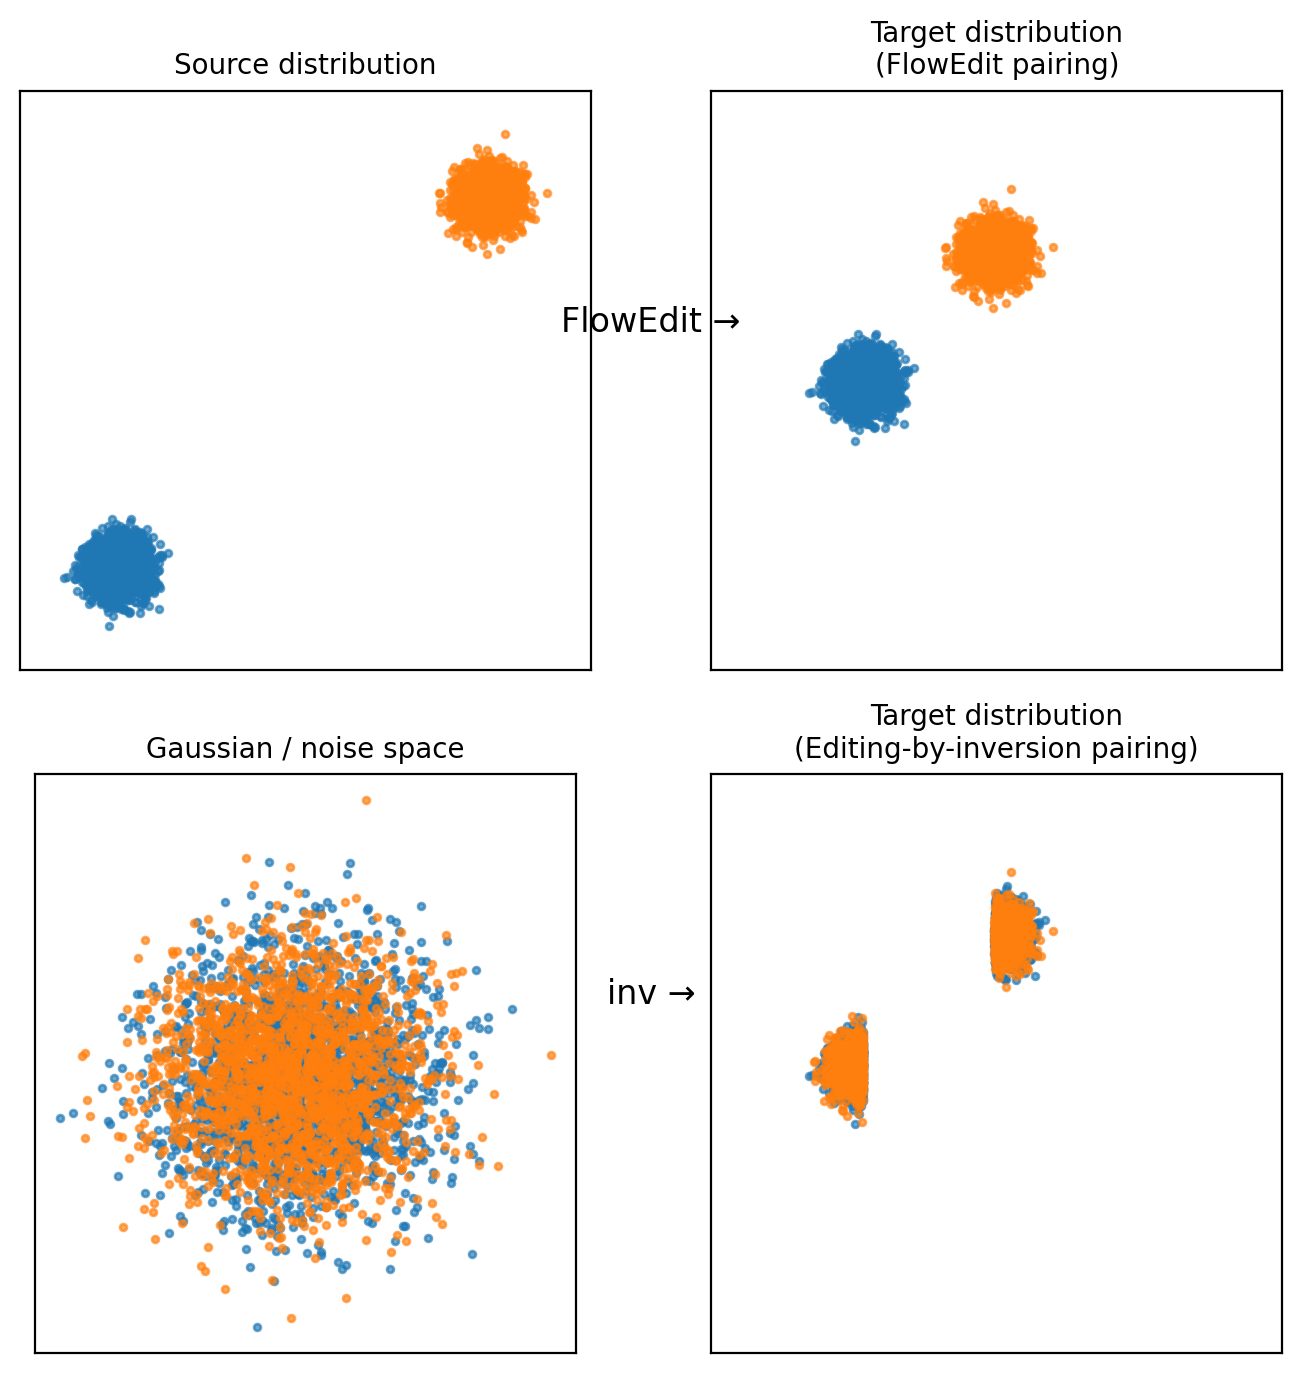

In [ ]:

MU_SRC = np.array([[-15*np.sqrt(2), -15*np.sqrt(2)],
                   [ 15*np.sqrt(2),  15*np.sqrt(2)]], dtype=np.float64)

MU_TAR = np.array([[-15.0, 0.0],
                   [  0.0, 15.0]], dtype=np.float64)


# ============================================================
# 1) FlowEdit (SPECIAL CASE ONLY, but respects your algorithm)
# ============================================================
def flowedit_special_case(X_src, mode, T=60, seed=123):
    """
    Respects your loop and formulas:
      Z_src_t = (1-t) X_src + t N
      Z_tar_t = Z + (Z_src_t - X_src)
      Z <- Z + dt * (V_tar - V_src)

    Here we build V so that (V_tar - V_src) = delta (pure translation per source mode),
    which preserves the cluster shape and keeps perfect pairing (no mixing).
    """
    rng = np.random.default_rng(seed)
    Z = X_src.copy()

    # fixed pairing: source mode 0 -> target mode 0, source mode 1 -> target mode 1
    delta = MU_TAR[mode] - MU_SRC[mode]   # (N,2) translation per point
    dt = 1.0 / T                          # ensures total shift ~ delta after T steps

    ts = np.linspace(1.0, 0.0, T, endpoint=True)  # high -> low noise

    for t in ts:
        N = rng.standard_normal(X_src.shape)  # N ~ N(0,I)

        # algorithm lines (kept)
        Z_src_t = (1.0 - t) * X_src + t * N
        Z_tar_t = Z + (Z_src_t - X_src)

        # SPECIAL velocity field (works for this toy only):
        # choose V_src = X_src - N, V_tar = (X_src + delta) - N  => V_tar - V_src = delta
        V_src = X_src - N
        V_tar = (X_src + delta) - N

        Z = Z + dt * (V_tar - V_src)

    return Z


# ============================================================
# 2) Editing-by-inversion (SPECIAL CASE ONLY)
# ============================================================
def editing_by_inversion_special_case(X_src, mode, sigma=1.8):
    """
    Emulates "inversion breaks correspondence":
    - invert each sample to a shared noise n_hat (both modes become N(0,I) => overlap)
    - regenerate target using a mode decision based only on noise (not on source mode)
      => each target cluster contains a mix of source colors.
    """
    # invert to noise (now all samples live in the same Gaussian space)
    n_hat = (X_src - MU_SRC[mode]) / sigma     # ~ N(0,I) for both modes

    # target mode chosen from noise ONLY (this is where correspondence breaks)
    k_tar = (n_hat[:, 0] > 0).astype(int)      # any gating works; this one is simple

    # generate target sample (keeps spread, no collapse!)
    Z_inv = MU_TAR[k_tar] + sigma * n_hat

    return Z_inv, n_hat


# ============================================================
# MAIN: reproduce Fig.3-like plot
# ============================================================
if __name__ == "__main__":
    rng = np.random.default_rng(7)
    N_PER_MODE = 2000
    sigma = 1.8

    # Source distribution: two Gaussian modes
    eps0 = rng.standard_normal((N_PER_MODE, 2))
    eps1 = rng.standard_normal((N_PER_MODE, 2))
    X0 = MU_SRC[0] + sigma * eps0
    X1 = MU_SRC[1] + sigma * eps1
    X_src = np.vstack([X0, X1])

    # SOURCE labels = colors (fixed, like paper)
    mode = np.array([0]*N_PER_MODE + [1]*N_PER_MODE)

    # Run both methods
    Z_fe = flowedit_special_case(X_src, mode, T=60, seed=123)
    Z_inv, X_noise = editing_by_inversion_special_case(X_src, mode, sigma=sigma)

    # Plot 2x2
    fig, axs = plt.subplots(2, 2, figsize=(7.2, 7.0), dpi=200)
    (ax1, ax2), (ax3, ax4) = axs

    def scat(ax, X, title):
        ax.scatter(X[mode==0, 0], X[mode==0, 1], s=6, alpha=0.65)
        ax.scatter(X[mode==1, 0], X[mode==1, 1], s=6, alpha=0.65)
        ax.set_title(title, fontsize=10)
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, linewidth=0.3, alpha=0.3)
        ax.set_xticks([]); ax.set_yticks([])

    scat(ax1, X_src,   "Source distribution")
    scat(ax2, Z_fe,    "Target distribution\n(FlowEdit pairing)")
    scat(ax3, X_noise, "Gaussian / noise space")
    scat(ax4, Z_inv,   "Target distribution\n(Editing-by-inversion pairing)")

    # consistent bounds for data-space panels
    all_xy = np.vstack([X_src, Z_fe, Z_inv, MU_SRC, MU_TAR])
    xmin, ymin = all_xy.min(axis=0) - 5
    xmax, ymax = all_xy.max(axis=0) + 5
    for ax in [ax1, ax2, ax4]:
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    fig.text(0.50, 0.76, "FlowEdit →", ha="center", va="center", fontsize=12)
    fig.text(0.50, 0.28, "inv →",     ha="center", va="center", fontsize=12)

    plt.tight_layout(pad=1.2)
    plt.show()
